In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


/home/ntapia/miniconda3/envs/idp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


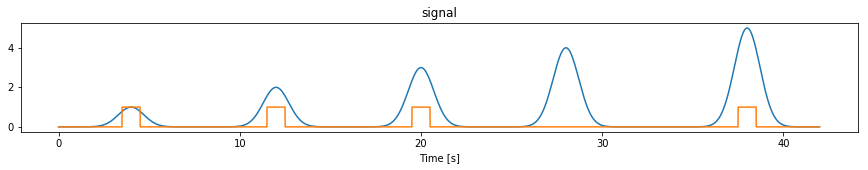

(8400,)


In [2]:
# Generate arbitrary signal
t = np.arange(0,42,1/200)
signal = np.exp(-(t-4)**2) + 2*np.exp(-(t-12)**2) + 3*np.exp(-(t-20)**2) + 4*np.exp(-(t-28)**2) + 5*np.exp(-(t-38)**2)
signal = np.array(signal, dtype=np.float32)
# And labels
labels = np.zeros(signal.shape, dtype=np.int32)
labels[700:900] = 1
labels[2300:2500] = 1
labels[3900:4100] = 1
labels[7500:7700] = 1

plt.figure(figsize=(15, 2))
plt.plot(t, signal)
plt.plot(t, labels)
plt.title('signal')
plt.xlabel('Time [s]')
plt.show()

print(t.shape)

Shape of dataset, feats: (1, 8400)
Shape of dataset, labels: (1, 8400)
Feats shape: (3, 4400) Labels shape: (3, 400)


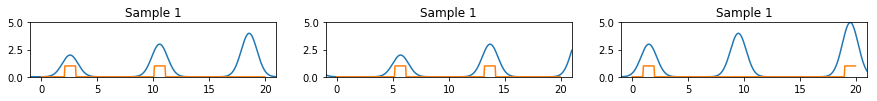

Feats shape: (3, 4400) Labels shape: (3, 400)


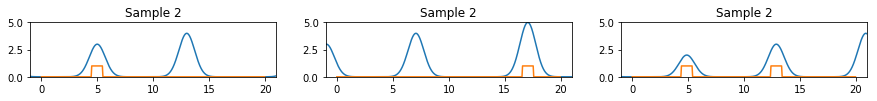

Feats shape: (3, 4400) Labels shape: (3, 400)


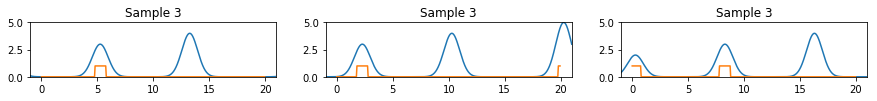

In [7]:
import random

tf.reset_default_graph()

def my_crop_fn(feat, label):
    fs = 200
    crop_size = 22*fs
    step_size = 10
    # Random crop
    #seed = random.random()
    #feat = tf.random_crop(feat, [crop_size], seed=seed)
    #label = tf.random_crop(label, [crop_size], seed=seed)
    label_cast = tf.cast(label, dtype=tf.float32)
    stack = tf.stack([feat, label_cast], axis=0)
    stack_crop = tf.random_crop(stack, [2, crop_size])
    feat = stack_crop[0,:]
    label_cast = stack_crop[1, fs:-fs:step_size]
    label = tf.cast(label_cast, dtype=tf.int32)
    # Throw first and last second for labels, skipping steps
    #label = label[fs:-fs:step_size]   
    return feat, label

# Create dataset
dataset_feats = np.array([signal])
dataset_labels = np.array([labels])
print("Shape of dataset, feats:", dataset_feats.shape)
print("Shape of dataset, labels:", dataset_labels.shape)


feats_ph = tf.placeholder(dtype=tf.float32, shape=dataset_feats.shape)
labels_ph = tf.placeholder(dtype=tf.int32, shape=dataset_labels.shape)

dataset_tf = tf.data.Dataset.from_tensor_slices((feats_ph, labels_ph))
dataset_tf = dataset_tf.repeat()
###

# Preprocessing step: random crop
dataset_tf = dataset_tf.map(my_crop_fn)

###
dataset_tf = dataset_tf.shuffle(buffer_size=100)
dataset_tf = dataset_tf.batch(batch_size=3)
dataset_tf = dataset_tf.prefetch(buffer_size=4)

# Iterator
iterator_tf = dataset_tf.make_initializable_iterator()

# Generate TF Dataset objects for each split
#    train_img_ph = tf.placeholder(dtype=tf.float32, shape=self.data_train.shape)
#    test_img_ph = tf.placeholder(dtype=tf.float32, shape=self.data_test.shape)
#    dataset_train = tf.data.Dataset.from_tensor_slices(train_img_ph)
#    dataset_test = tf.data.Dataset.from_tensor_slices(test_img_ph)
#    dataset_train = dataset_train.repeat()
#    dataset_test = dataset_test.repeat()

    # Random batching
#    dataset_train = dataset_train.shuffle(buffer_size=5000)
#    dataset_train = dataset_train.batch(batch_size=batch_size)
#    dataset_test = dataset_test.shuffle(buffer_size=1000)
#    dataset_test = dataset_test.batch(batch_size=batch_size)

    # Prefetch
#    dataset_train = dataset_train.prefetch(buffer_size=4)
#    dataset_test = dataset_test.prefetch(buffer_size=4)

    # Iterator for each split
#    iterator_train = dataset_train.make_initializable_iterator()
#    iterator_test = dataset_test.make_initializable_iterator()

    # Global iterator
#    handle = tf.placeholder(tf.string, shape=[])
#    iterator = tf.data.Iterator.from_string_handle(
#        handle, dataset_train.output_types, dataset_train.output_shapes)


element_feats, element_labels = iterator_tf.get_next()

with tf.Session() as sess:
    # Initialization of variables
    sess.run(tf.global_variables_initializer())
    # Initialization of iterators
    sess.run(iterator_tf.initializer, feed_dict={feats_ph: dataset_feats, labels_ph: dataset_labels})
    
    # Get elements
    for i in range(3):
        numpy_feats, numpy_labels = sess.run([element_feats, element_labels])
        print("Feats shape:",numpy_feats.shape,"Labels shape:", numpy_labels.shape)
        n_batch = numpy_feats.shape[0]
        plt.figure(figsize=(15, 1))
        for j in range(n_batch):
            plt.subplot(1,n_batch,j+1)
            plt.plot(np.arange(-1,21,1/200), numpy_feats[j,:])
            plt.plot(np.arange(0,20,1/20), numpy_labels[j,:])
            plt.title('Sample '+str(i+1))
            plt.xlim([-1,21])
            plt.ylim([0,5])
        plt.show()